# Economic Indicator Features

This notebook aims to explore the impact of economic features on sales. Questions this notebook aims to answer include: 
1. How does ecnomic features impact sales for items in different departments?
2. How are items individuall affected by economic indicators? 
3. What is the best way to signal the model the nature of the individual item based on this features?

An important piece of information is that 2011 is not a complete date. This is what was driving the odd rolling averages. I need to fix this everywhere. 
Like wise I have learned that the last month (2016-03) is incomplete. I will filter it now. 

My conclussion here is that after applying differencing, these features lose their predictive value as the majority of it revovled around capturing the downard trend of the sales.

In [1]:
# Import required libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
"""

econ_features_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_featurestore.economic_indicator_features`
"""
# Extract data
item_sales = bq_client.load_from_query(sales_query)
econ_features = bq_client.load_from_query(econ_features_query)

item_sales = item_sales[item_sales["tgt_monthly_sales"]>0]
item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2015-11-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    econ_features,
    on=["ctx_date_month"]
)




/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 121003 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 84 rows from custom query.


# Utils functions



In [2]:

# Create regression iteration function
def iterate_regression_over_features_and_departments(event_cols, target_name = "tgt_monthly_sales_sum_3_next_months"):
    results = {}
    significant_results = []
    for event_col in event_cols:
        df_merged[event_col] = df_merged[event_col].fillna(0)
        df_merged[event_col] = df_merged[event_col].astype(float)
        for dept in df_merged['ctx_dept_id'].unique():
            dept_df = df_merged[df_merged['ctx_dept_id'] == dept].copy()
            X = dept_df[event_col]
            X = sm.add_constant(X)
            y = dept_df[target_name]
            model = sm.OLS(y, X, missing='drop').fit()
            results[dept+"-"+event_col] = model
            coef = model.params.get(event_col, None)
            pval = model.pvalues.get(event_col, None)
            if coef is not None and pval is not None and pval < 0.06:
                significant_results.append({'department': dept, 'coef': coef, 'p_value': pval, 'feature': event_col})
    df_significant = pd.DataFrame(significant_results)
    df_significant["abs_coef"] = df_significant["coef"].abs()
    return results, df_significant


# department plots with secondary axis for an economic indicator

def plot_economic_indicator_vs_dept_sales(dept_list, fea_econ_name):
    plt.figure(figsize=(12,5))
    ax1 = plt.gca()

    for dept in dept_list:
        item_sales_focus = df_merged[df_merged['ctx_dept_id'] == dept]
        sales_median = item_sales_focus.groupby('ctx_date_month')['tgt_monthly_sales_sum_3_next_months_diffed'].median().reset_index()
        sns.lineplot(
            data=sales_median,
            x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months_diffed', marker='o', label=f"{dept} Sales", ax=ax1
        )

    ax2 = ax1.twinx()
    # Plot the secondary feature (example: fea_ca_unemployment_rate)
    econ_feature = df_merged.groupby('ctx_date_month')[fea_econ_name].sum().reset_index()
    sns.lineplot(
        data=econ_feature,
        x='ctx_date_month', y=fea_econ_name, color='black', marker='x', label=fea_econ_name, ax=ax2
    )

    ax1.set_title(f'Sum Monthly Sales Per Department Over Time with {fea_econ_name}')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Sum Sales')
    ax2.set_ylabel('Unemployment Rate')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left', title='Department')
    ax2.legend(loc='upper right', title='Economic Indicator')
    plt.tight_layout()
    plt.show()


# Apply Differencing

In [3]:
# Example: Apply first-order differencing to a specific column
df_merged["fea_cpi_food_inverted"] = 300 - df_merged["fea_cpi_food"]
df_merged['tgt_monthly_sales_sum_3_next_months_diffed'] = df_merged.groupby('ctx_item_id')['tgt_monthly_sales_sum_3_next_months'].diff()
df_merged['fea_ca_unemployment_rate_diffed'] = df_merged.groupby('ctx_item_id')['fea_ca_unemployment_rate'].diff()
df_merged['fea_gas_price_per_gallon_diffed'] = df_merged.groupby('ctx_item_id')['fea_gas_price_per_gallon'].diff()
df_merged['fea_cpi_food_inverted_diffed'] = df_merged.groupby('ctx_item_id')['fea_cpi_food_inverted'].diff()


# Regression per dept

In [4]:
EVENT_COLS = ['fea_ca_unemployment_rate_diffed',
       'fea_gas_price_per_gallon_diffed', 'fea_cpi_food_inverted_diffed']

results, df_significant = iterate_regression_over_features_and_departments(event_cols=EVENT_COLS, target_name = "tgt_monthly_sales_sum_3_next_months_diffed")



In [5]:
df_significant

,department,coef,p_value,feature,abs_coef
0,FOODS_1,2.280400,3.749614e-04,fea_ca_unemployment_rate_diffed,2.280400
1,FOODS_2,7.859372,1.406959e-72,fea_ca_unemployment_rate_diffed,7.859372
2,FOODS_3,12.898946,5.233031e-73,fea_ca_unemployment_rate_diffed,12.898946
3,HOBBIES_1,5.251178,2.122824e-47,fea_ca_unemployment_rate_diffed,5.251178
4,HOUSEHOLD_1,1.209455,5.157252e-07,fea_ca_unemployment_rate_diffed,1.209455
5,HOUSEHOLD_2,0.636876,2.824778e-14,fea_ca_unemployment_rate_diffed,0.636876
6,HOBBIES_2,-2.078273,4.494201e-06,fea_ca_unemployment_rate_diffed,2.078273
7,FOODS_1,8.283962,2.684466e-04,fea_gas_price_per_gallon_diffed,8.283962
8,FOODS_2,15.698851,1.496841e-23,fea_gas_price_per_gallon_diffed,15.698851
9,FOODS_3,41.346427,3.389982e-60,fea_gas_price_per_gallon_diffed,41.346427


# Capturing the trend

1. fea_ca_unemployment_rate:
    - Unemployment rate does not provide with much usefulness appart from just being a downward slope curve. 
    - Other than the trend of foods going down there is not mcuh value. 
    - It does not caputre the suttle recovery of foods dales later in 2015. 

2. fea_gas_price_per_gallon:
    - I don't see it closely matching the curve for any departmentment. Foods match it closer than the rest, but it is still not suficient.

3. 

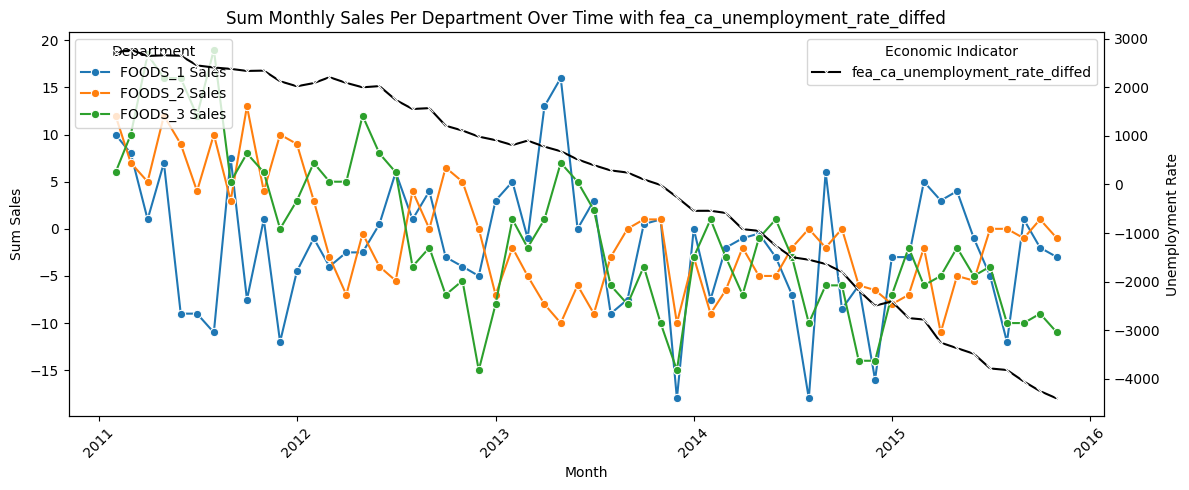

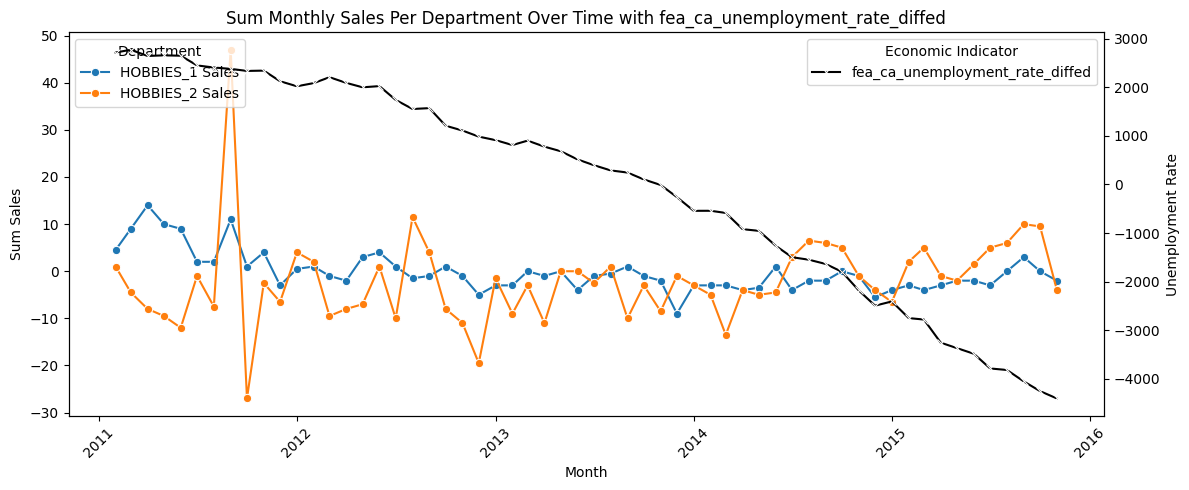

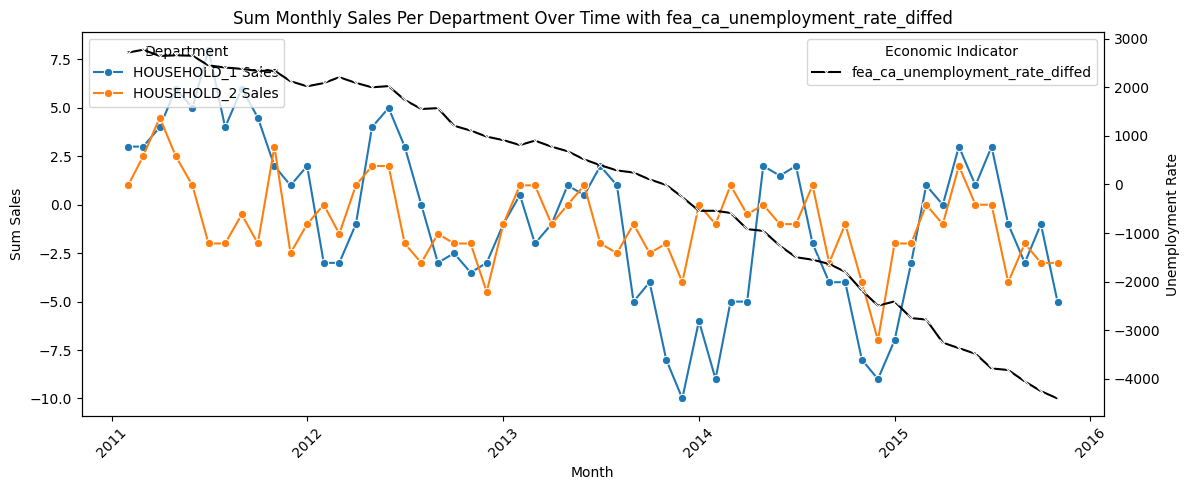

In [6]:
# department plots with secondary axis for an economic indicator

plot_economic_indicator_vs_dept_sales(["FOODS_1", "FOODS_2", "FOODS_3"], "fea_ca_unemployment_rate_diffed")
plot_economic_indicator_vs_dept_sales(["HOBBIES_1", "HOBBIES_2"], "fea_ca_unemployment_rate_diffed")
plot_economic_indicator_vs_dept_sales(["HOUSEHOLD_1", "HOUSEHOLD_2"], "fea_ca_unemployment_rate_diffed")

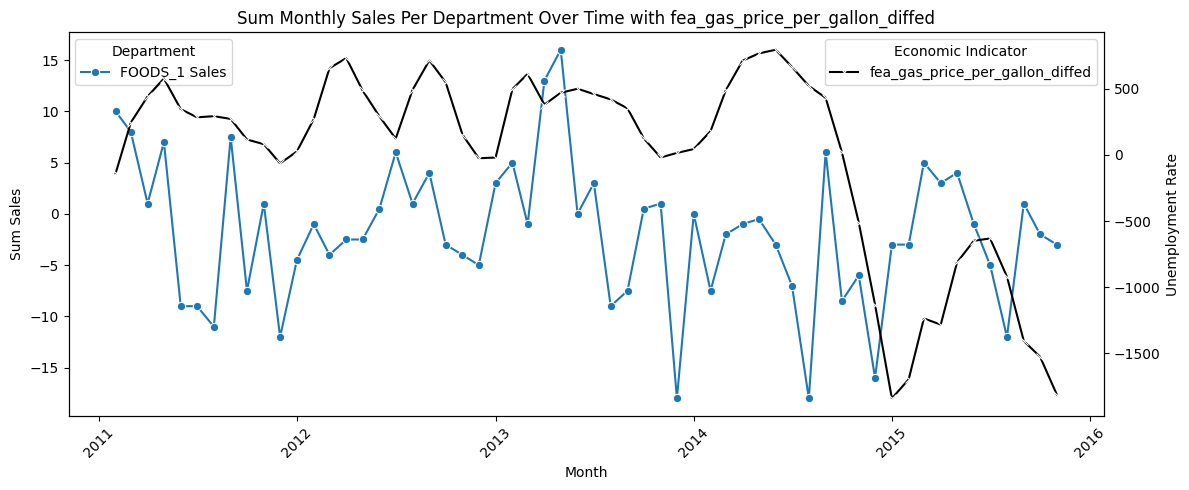

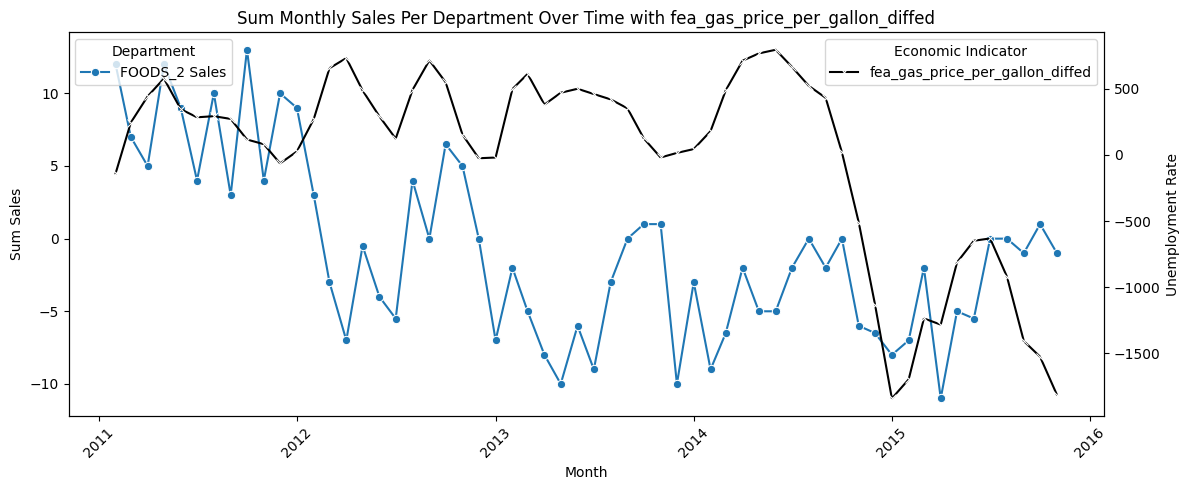

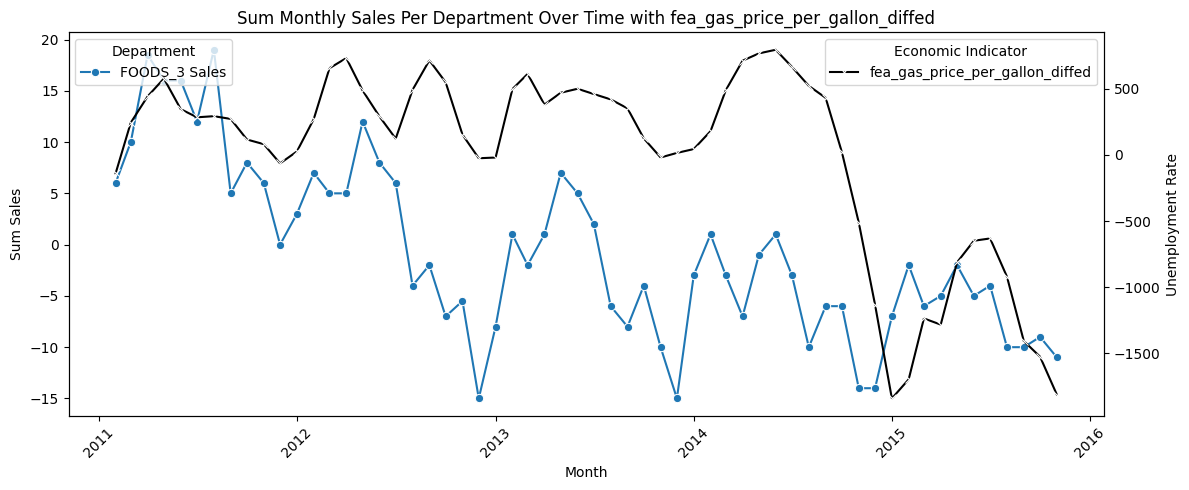

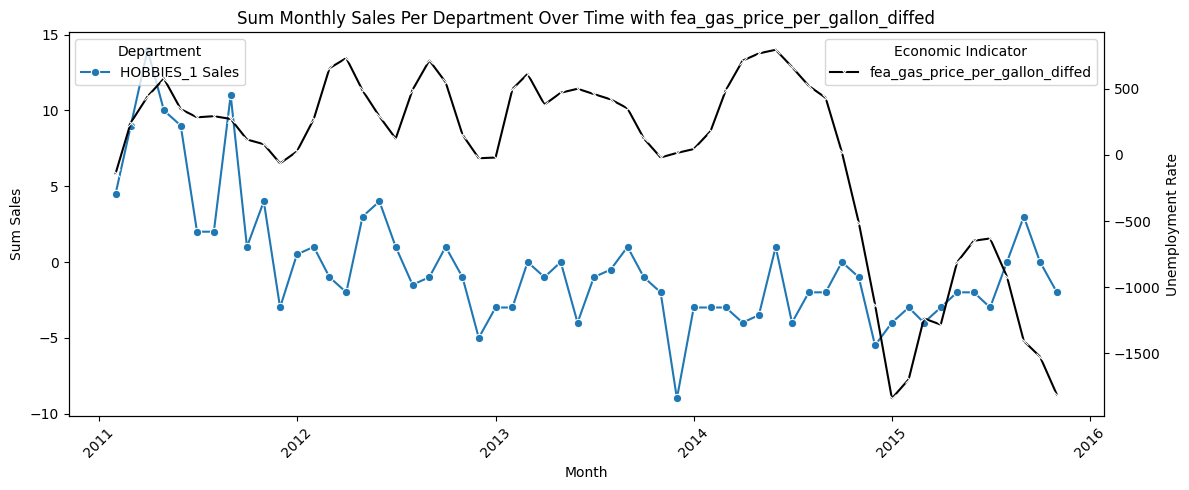

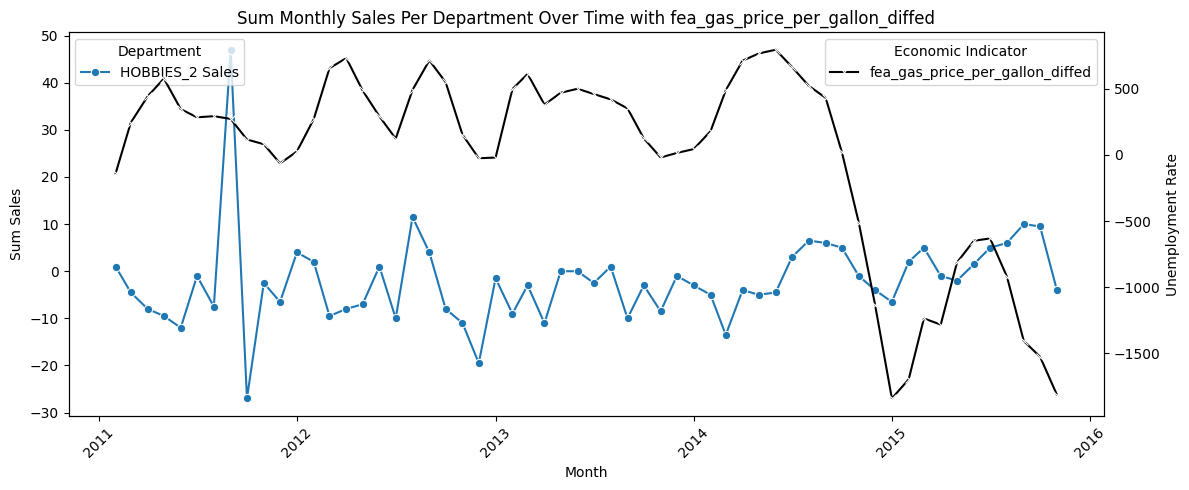

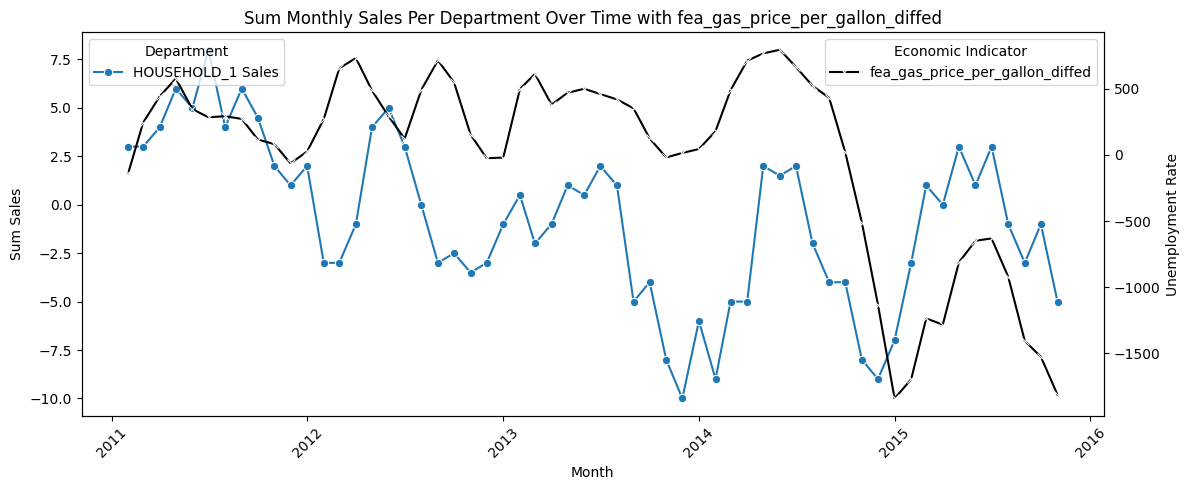

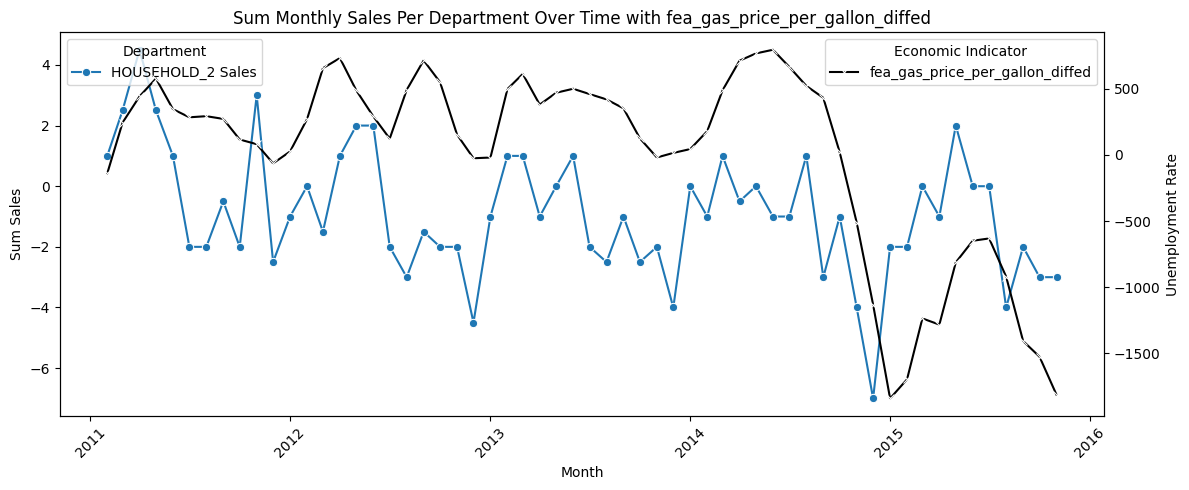

In [7]:
# department plots with secondary axis for an economic indicator

plot_economic_indicator_vs_dept_sales(["FOODS_1"], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["FOODS_2",], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["FOODS_3",], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["HOBBIES_1",], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["HOBBIES_2",], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["HOUSEHOLD_1",], "fea_gas_price_per_gallon_diffed")
plot_economic_indicator_vs_dept_sales(["HOUSEHOLD_2",], "fea_gas_price_per_gallon_diffed")

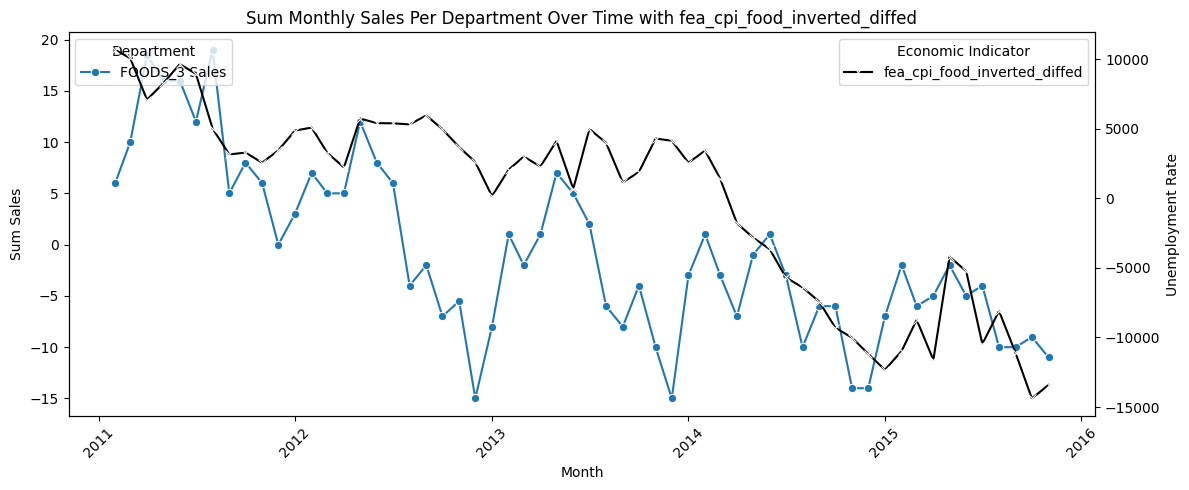

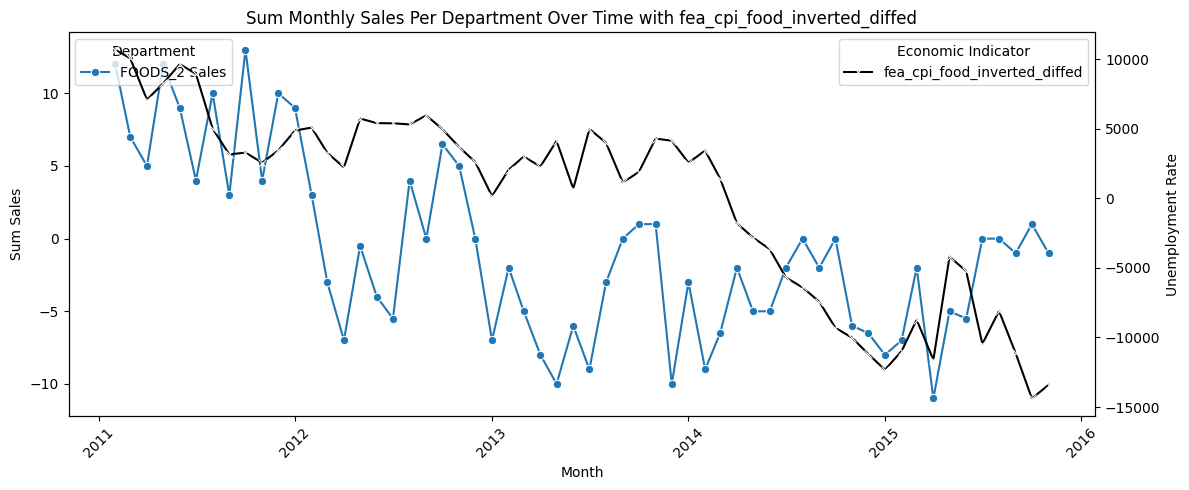

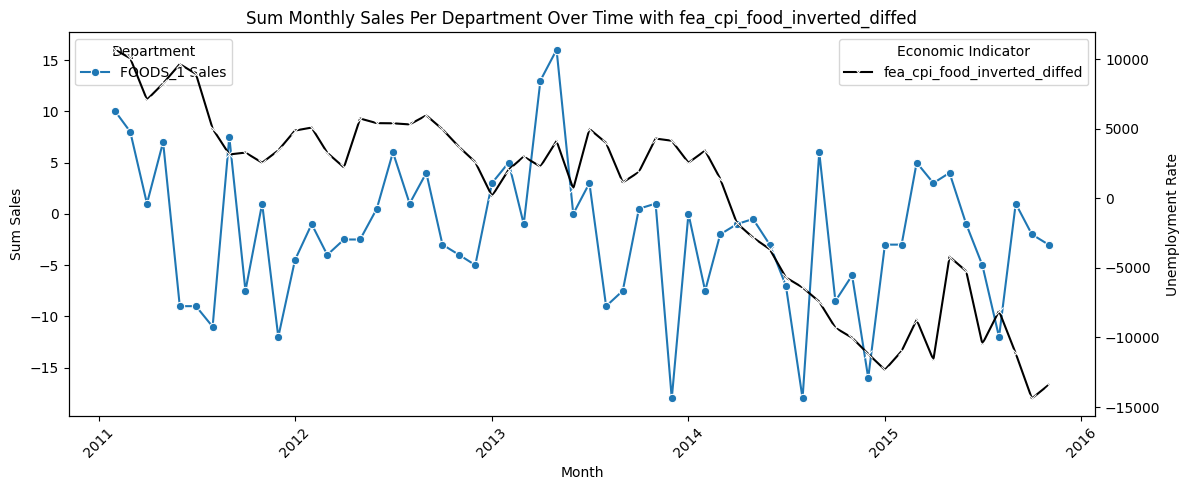

In [8]:
# department plots with secondary axis for an economic indicator

plot_economic_indicator_vs_dept_sales(["FOODS_3"], "fea_cpi_food_inverted_diffed")
plot_economic_indicator_vs_dept_sales(["FOODS_2"], "fea_cpi_food_inverted_diffed")
plot_economic_indicator_vs_dept_sales(["FOODS_1"], "fea_cpi_food_inverted_diffed")

# Exploring individual effect: 

1. fea_cpi_food_inverted_diffed: Would only apply to 35 individual food items.
2. fea_gas_price_per_gallon_diffed: Would only apply to 38 individual items.

In [9]:
feature_name = "fea_gas_price_per_gallon_diffed"
df_merged[feature_name] = df_merged[feature_name].fillna(0)
df_merged[feature_name] = df_merged[feature_name].astype(float)
significant_results = []
for item in df_merged["ctx_item_id"].unique():
    df_specific_item = df_merged[df_merged["ctx_item_id"] == item]
    unique_dates = df_specific_item["ctx_date_month"].unique()
    for cutoff_date in unique_dates:
        df_specific_item_cutoff = df_specific_item[df_specific_item["ctx_date_month"] <= cutoff_date]
        if df_specific_item_cutoff.shape[0]>=12:
            X = df_specific_item_cutoff[[feature_name]]
            X = sm.add_constant(X)
            y = df_specific_item_cutoff['tgt_monthly_sales_sum_3_next_months_diffed']
            model = sm.OLS(y, X).fit()
            pval = model.pvalues[feature_name]
            if pval < 0.05:
                significant_results.append({
                    'ctx_item_id': item, 
                    f'{feature_name}_p_value': pval, 
                    f'{feature_name}_coef': model.params[feature_name],
                    'ctx_date_month_cutoff': cutoff_date})

import pandas as pd
df_significant = pd.DataFrame(significant_results)

In [10]:
# Fix: add 3 months to ctx_date_month_cutoff using pd.DateOffset
import pandas as pd

df_significant["ctx_date_month"] = pd.to_datetime(df_significant["ctx_date_month_cutoff"])
df_merged["ctx_date_month"] = pd.to_datetime(df_merged["ctx_date_month"])
df_merged_significant = df_merged.merge(
    df_significant[['ctx_item_id', 'ctx_date_month',  f'{feature_name}_p_value', f'{feature_name}_coef']],
    on=['ctx_item_id', 'ctx_date_month'],
    how='left'
)

df_merged_significant[f"{feature_name}_nonnull"] = 0
df_merged_significant.loc[
    ~df_merged_significant[f"{feature_name}_p_value"].isna(),
    f"{feature_name}_nonnull"
] = 1

df_reliable_3m = df_merged_significant.groupby(
    ["ctx_item_id"]
)[[f"{feature_name}_nonnull"]].mean().sort_values(by=f"{feature_name}_nonnull", ascending=False).reset_index()

df_reliable_3m = df_reliable_3m[
    df_reliable_3m[f"{feature_name}_nonnull"]>0.50
]

df_merged_significant_filtered = df_merged_significant.merge(
    df_reliable_3m[["ctx_item_id"]],
    on="ctx_item_id",
    how="inner"
)

df_merged_significant_filtered[["ctx_item_id", "ctx_dept_id"]].drop_duplicates().shape

(38, 2)